In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from Class_vogn import train_model_cc_fast,csvDataset,ToTensor
import torch.nn.functional as F
from active_function import *
from sklearn.model_selection import train_test_split
from vogn import VOGN


In [9]:
Xtrain = np.load('eightPhasePowerStage_dc_dc_v2_lbl/trainx.npy')
Ytrain = np.load('eightPhasePowerStage_dc_dc_v2_lbl/trainy.npy')*1.
Xtest = np.load('eightPhasePowerStage_dc_dc_v2_lbl/testx.npy')
Ytest = np.load('eightPhasePowerStage_dc_dc_v2_lbl/testy.npy')*1.


for i in range(8):
    Xtrain[:,i]=(Xtrain[:,i] - Xtrain[:,i].mean())/(Xtrain[:,i].std()+1e-10)
    Xtest[:,i]=(Xtest[:,i] - Xtest[:,i].mean())/(Xtest[:,i].std()+1e-10)
Ytrain = Ytrain.reshape(-1,1)
Ytest = Ytest.reshape(-1,1) 


In [16]:
Xtrain = np.load('eightPhasePowerStage_dc_dc_v2_lbl/trainx.npy')
Ytrain = np.load('eightPhasePowerStage_dc_dc_v2_lbl/trainy.npy')*1.
Xtest = np.load('eightPhasePowerStage_dc_dc_v2_lbl/testx.npy')
Ytest = np.load('eightPhasePowerStage_dc_dc_v2_lbl/testy.npy')*1.
Xtrain = Xtrain[:,1:7]
Xtrain.shape

(254, 6)

In [17]:
np.std(Xtrain,axis=0)

array([1.4044302e+07, 1.7145092e+01, 4.2890785e+01, 3.3316960e+00,
       8.5871410e+00, 3.4468657e-01], dtype=float32)

In [12]:
Xtrain = Xtrain[1:6]
Xtrain.shape

In [4]:
Xtrain

array([[ 0.        , -0.00280313, -0.9814336 , ..., -0.33606377,
        -1.1621884 ,  0.        ],
       [ 0.        , -1.4268677 ,  1.1766182 , ...,  1.1778282 ,
         0.28840554,  0.        ],
       [ 0.        , -1.4268677 ,  0.82666385, ...,  0.82846856,
         1.0137025 ,  0.        ],
       ...,
       [ 0.        ,  1.4212614 ,  1.001641  , ...,  1.061375  ,
        -0.43689147,  0.        ],
       [ 0.        , -0.00280313,  0.12675516, ..., -0.33606377,
        -0.43689147,  0.        ],
       [ 0.        ,  1.4212614 ,  0.30173233, ...,  0.24620238,
        -0.43689147,  0.        ]], dtype=float32)

In [5]:
class EvalNet(nn.Module):
    def __init__(self, in_size=8, dropout_rate=None):
        super(type(self), self).__init__()
        self.dropout = dropout_rate
        if dropout_rate:
            self.dropout = nn.Dropout(dropout_rate)
        self.f1 = nn.Linear(in_size, 64)
        self.f2 = nn.Linear(64,  128)
        self.f3 = nn.Linear(128,  128)
        self.f4 = nn.Linear(128,  1)

    def forward(self, x):
        out = x
        out = F.relu(self.f1(out))
        if self.dropout:
            out = self.dropout(out)
        out = F.relu(self.f2(out))
        if self.dropout:
            out = self.dropout(out)
        out =F.relu(self.f3(out))
        out =self.f4(out)
        return out
    
class BaseNet(nn.Module):
    def __init__(self,dropout_rate=None):
        super(type(self), self).__init__()
        self.dropout = dropout_rate
        if dropout_rate:
            self.dropout = nn.Dropout(dropout_rate)
        self.layer1 = nn.Linear(8, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, 1)
        
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        if self.dropout:
            out = self.dropout(out)
        x = F.relu(self.layer2(x))
        if self.dropout:
            out = self.dropout(out)
        out = self.layer3(x)
        return out    

In [12]:
correct = np.zeros(100)
for x in range(10):
    a = np.random.choice(254,10+10*x,replace=False)
    Xtrainb=Xtrain[a]
    Ytrainb=Ytrain[a]
    model = BaseNet()
    optimizer = VOGN(model, train_set_size=1000,prior_prec=30, prec_init=30, num_samples=4)

    use_cuda = torch.cuda.is_available()
    inference_dataset = csvDataset(Xtest,Ytest,transform= ToTensor())
    inference_loader = torch.utils.data.DataLoader(inference_dataset,batch_size=Xtest.shape[0], shuffle=False)
    
    file_dataset = csvDataset(Xtrainb,Ytrainb,transform= ToTensor())
    final_loader = torch.utils.data.DataLoader(file_dataset,batch_size=1 ,shuffle=False)

    if use_cuda:
        model = model.float().cuda()

    criterion = F.binary_cross_entropy_with_logits
    model, train_accuracy,ep= train_model_cc_fast(model, final_loader, criterion, optimizer,Xtrain.shape[0], num_epochs=50)
    print(ep)
    model.eval()
    with torch.no_grad():
        for i in inference_loader:
            inputs = i['data']
            labels = i['label']
            inputs, labels = inputs.cuda(), labels.cuda()
            out = model.forward(inputs)
            pred = (out.cpu().numpy()>0)*1.
            labels = (labels.cpu().numpy())*1.

    correct[x] =(np.sum(pred==labels)/Xtest.shape[0])

49
49
49
49
49
49
49
49
49
49


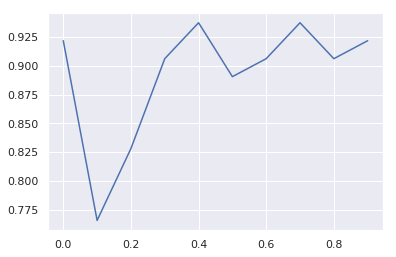

In [13]:
plt.plot(np.arange(10)/10,correct[:10])

In [14]:
correct = np.zeros(100)
for x in range(10):
    a = np.random.choice(254,10+10*x,replace=False)
    Xtrainb=Xtrain[a]
    Ytrainb=Ytrain[a]
    model = BaseNet()
    optimizer = VOGN(model, train_set_size=100,prior_prec=30, prec_init=30, num_samples=4)

    use_cuda = torch.cuda.is_available()
    inference_dataset = csvDataset(Xtest,Ytest,transform= ToTensor())
    inference_loader = torch.utils.data.DataLoader(inference_dataset,batch_size=Xtest.shape[0], shuffle=False)
    
    file_dataset = csvDataset(Xtrainb,Ytrainb,transform= ToTensor())
    final_loader = torch.utils.data.DataLoader(file_dataset,batch_size=1 ,shuffle=False)

    if use_cuda:
        model = model.float().cuda()

    criterion = F.binary_cross_entropy_with_logits
    model, train_accuracy,ep= train_model_cc_fast(model, final_loader, criterion, optimizer,Xtrain.shape[0], num_epochs=50)
    print(ep)
    model.eval()
    with torch.no_grad():
        for i in inference_loader:
            inputs = i['data']
            labels = i['label']
            inputs, labels = inputs.cuda(), labels.cuda()
            out = model.forward(inputs)
            pred = (out.cpu().numpy()>0)*1.
            labels = (labels.cpu().numpy())*1.

    correct[x] =(np.sum(pred==labels)/Xtest.shape[0])

49
49
49
49
49
49
49
49
49
49


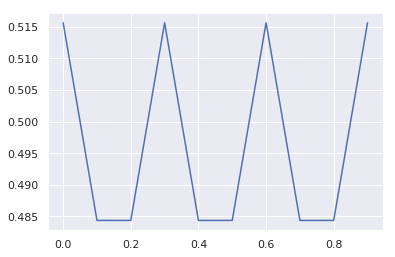

In [15]:
plt.plot(np.arange(10)/10,correct[:10])

In [18]:
correct = np.zeros(100)
for x in range(10):
    a = np.random.choice(254,20,replace=False)
    Xtrainb=Xtrain[a]
    Ytrainb=Ytrain[a]
    model = BaseNet()
    optimizer = VOGN(model, train_set_size=100+x*200,prior_prec=30, prec_init=30, num_samples=4)

    use_cuda = torch.cuda.is_available()
    inference_dataset = csvDataset(Xtest,Ytest,transform= ToTensor())
    inference_loader = torch.utils.data.DataLoader(inference_dataset,batch_size=Xtest.shape[0], shuffle=False)
    
    file_dataset = csvDataset(Xtrainb,Ytrainb,transform= ToTensor())
    final_loader = torch.utils.data.DataLoader(file_dataset,batch_size=1 ,shuffle=False)

    if use_cuda:
        model = model.float().cuda()

    criterion = F.binary_cross_entropy_with_logits
    model, train_accuracy,ep= train_model_cc_fast(model, final_loader, criterion, optimizer,Xtrain.shape[0], num_epochs=50)
    print(ep)
    model.eval()
    with torch.no_grad():
        for i in inference_loader:
            inputs = i['data']
            labels = i['label']
            inputs, labels = inputs.cuda(), labels.cuda()
            out = model.forward(inputs)
            pred = (out.cpu().numpy()>0)*1.
            labels = (labels.cpu().numpy())*1.

    correct[x] =(np.sum(pred==labels)/Xtest.shape[0])

49
49
49
49
49
49
49
49
49
49


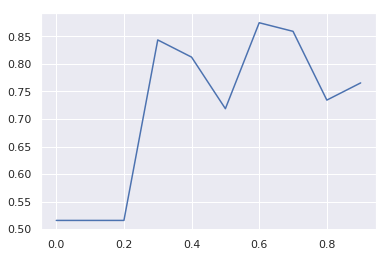

In [19]:
plt.plot(np.arange(10)/10,correct[:10])

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from vogn_utils import train_model_cc_fast,csvDataset,ToTensor
import torch.nn.functional as F


class EvalNet(nn.Module):
    def __init__(self, in_size=8, dropout_rate=None):
        super(type(self), self).__init__()
        self.dropout = dropout_rate
        if dropout_rate:
            self.dropout = nn.Dropout(dropout_rate)
        self.f1 = nn.Linear(in_size, 64)
        self.f2 = nn.Linear(64,  128)
        self.f3 = nn.Linear(128,  128)
        self.f4 = nn.Linear(128,  1)

    def forward(self, x):
        out = x
        out = F.relu(self.f1(out))
        if self.dropout:
            out = self.dropout(out)
        out = F.relu(self.f2(out))
        if self.dropout:
            out = self.dropout(out)
        out =self.f3(out)
        out =self.f4(out)
        return out  
    
correct = np.zeros(100)
for x in range(100):
    
    model = EvalNet()
    optimizer = optim.Adam(model.parameters(), weight_decay=0.0001*x)

    use_cuda = torch.cuda.is_available()
    inference_dataset = csvDataset(Xtest,Ytest,transform= ToTensor())
    inference_loader = torch.utils.data.DataLoader(inference_dataset,batch_size=Xtest.shape[0], shuffle=False)
    file_dataset = csvDataset(Xtrain,Ytrain,transform= ToTensor())
    final_loader = torch.utils.data.DataLoader(file_dataset,batch_size=Xtrain.shape[0], shuffle=False)

    if use_cuda:
        model = model.float().cuda()

    criterion = F.binary_cross_entropy_with_logits
    model, train_loss, train_accuracy = train_model_cc_fast(model, [final_loader, final_loader], criterion,
    optimizer, num_epochs=50)
    model.eval()
    with torch.no_grad():
        for i in inference_loader:
            inputs = i['data']
            labels = i['label']
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            out = model.forward(inputs)
            pred = (out.cpu().numpy()>0)*1.
            labels = (labels.cpu().numpy())*1.

    correct[x] =(np.sum(pred==labels)/Xtest.shape[0])
    
    plt.plot(np.arange(100)/10000,correct)

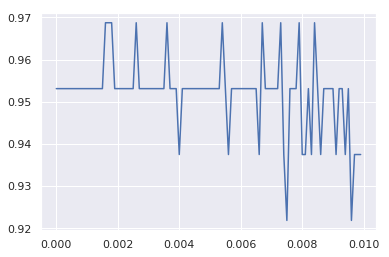

In [38]:
plt.plot(np.arange(100)/10000,correct)

In [8]:
correct[0]

0.953125